In [1]:
import os, time
import datetime as dt
import pandas as pd
from multiprocessing import Pool, cpu_count
import Settings
SOURCE = Settings.NETFLOW_PROS

In [2]:
from tqdm.notebook import tqdm
from tqdm.notebook import tnrange

In [3]:
INTERVAL = 5
if __name__ == '__main__':
    conv_files = list(filter(lambda x: x.startswith('feather_'), os.listdir(SOURCE)))
    print('[INFO] Starting conversion')
    print(f'[INFO] {len(conv_files)} files found in directory {os.getcwd()}{SOURCE[1:]}')
    df = pd.read_feather(SOURCE+'/'+conv_files[0])
    df['Duration'] = df['Duration'].map(lambda x: dt.timedelta(seconds=x))
    df['Datetime_lastseen'] = df['Datetime_firstseen']+df['Duration']
    if True:
        dfs=[df]
        for file in tqdm(conv_files[1:]):
            tempdf = pd.read_feather(SOURCE+'/'+file)
            tempdf['Duration'] = tempdf['Duration'].map(lambda x: dt.timedelta(seconds=x))
            tempdf['Datetime_lastseen'] = tempdf['Datetime_firstseen']+df['Duration']
            dfs.append(tempdf)
        df = pd.concat(dfs, ignore_index=True)
#     df.sort_values(by=['Datetime_firstseen'], inplace=True)
#     df.reset_index(inplace=True, drop=True)

#     pool = Pool(processes=4)
#     dfs = pool.map(process_nfdump, conv_files)

[INFO] Starting conversion
[INFO] 7 files found in directory D:\Users\Geovanni\Sync\PhD\Data\Conv


In [4]:
display(df.shape)
df

(9496587, 14)

,Datetime_firstseen,Duration,Protocol,Src_IP_Addr,Src_Port,Direc,Dst_IP_Addr,Dst_Port,Flags,Tos,Packets,Bytes,Flows,Datetime_lastseen
0,2020-02-07 23:54:53.840,00:04:50.310000,UDP,134.193.92.68,500,->,209.85.235.189,500,........,0,121,52824,1,2020-02-07 23:59:44.150
1,2020-02-07 23:57:52.820,00:01:51.696000,TCP,172.217.9.132,443,->,134.193.198.19,62831,...AP...,128,2521,1800000,1,2020-02-07 23:59:44.516
2,2020-02-07 23:58:01.226,00:01:43.250000,TCP,172.217.1.238,443,->,134.193.198.19,62833,...AP...,0,1225,990522,1,2020-02-07 23:59:44.476
3,2020-02-07 23:58:34.242,00:01:10.006000,TCP,134.193.254.218,49345,->,150.199.7.126,443,...APRS.,0,715,41665,1,2020-02-07 23:59:44.248
4,2020-02-07 23:58:43.858,00:01:01.010000,TCP,136.34.135.223,51053,->,134.193.136.193,443,...AP.SF,0,16,1832,1,2020-02-07 23:59:44.868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9496582,2020-02-08 00:34:43.987,00:00:00,TCP,45.227.254.30,49116,->,204.56.1.75,33898,......S.,0,1,40,1,NaT
9496583,2020-02-08 00:34:43.987,00:00:00,TCP,134.49.252.240,58357,->,134.193.25.80,80,......S.,0,1,44,1,NaT
9496584,2020-02-08 00:34:43.987,00:00:00,TCP,92.63.194.115,40352,->,134.193.157.232,35543,......S.,0,1,40,1,NaT
9496585,2020-02-08 00:34:43.987,00:00:00,TCP,198.209.56.129,443,->,134.193.244.195,52995,...AP...,0,1,109,1,NaT


In [5]:
interval_sum = pd.DataFrame(pd.date_range(start=df.Datetime_firstseen.min(), 
                                           end=df.Datetime_lastseen.max(), 
                                           freq=f'{INTERVAL}S'))
interval_sum[1] = [0] * len(interval_sum)
interval_sum.columns = ['datespace', 'sum of data transfer']
print(f'{interval_sum.datespace.min()}\t->\t{interval_sum.datespace.max()}')
interval_sum.set_index('datespace', inplace=True)

# interval_sum = interval_sum.iloc[:int(len(interval_sum)*.25),:]
# interval_sum

2020-02-07 23:30:00.056000	->	2020-02-08 01:04:30.056000


In [6]:
import math
def calculate_resampled_bytes(row, starttime, inter):
    num_interval_transfer = math.ceil(row['Duration'].total_seconds()/inter)
    avg_rate_of_transfer = row['Bytes']/num_interval_transfer
    list_of_bytes_across_intervals = [avg_rate_of_transfer]*num_interval_transfer
    return list_of_bytes_across_intervals

In [7]:
current_point = 0
stop=False
progress = [x for x in range(0,105,5)]
interval_index_list = list(interval_sum.index)
interval_sum_length = interval_sum.shape[0]
for interval_datetime in tqdm(interval_index_list):
    if interval_index_list.index(interval_datetime)/interval_sum_length >= progress[0]/100:
        print(f'At {interval_datetime}\t{interval_index_list.index(interval_datetime)}\t{progress.pop(0)}%')
    current_interval_index = interval_index_list.index(interval_datetime)
    df_inside_interval = df[(df.Datetime_firstseen >= interval_datetime) & (df.Datetime_firstseen < interval_datetime+dt.timedelta(seconds=INTERVAL))]
#     for ind, row in tqdm(df_inside_interval.iterrows(), total=df_inside_interval.shape[0], leave=False, position=1):
    for ind, row in df_inside_interval.iterrows():
        if row['Datetime_firstseen'] + row['Duration'] >= interval_datetime+dt.timedelta(seconds=5):
            resampled_bytes = calculate_resampled_bytes(row, interval_datetime, INTERVAL)
            for pos, transfer in enumerate(resampled_bytes):
                try:
                    interval_sum.iloc[current_interval_index+pos]+=transfer                    
                except:
                    date_range = pd.date_range(start=interval_sum.index[-1], 
                                               periods=len(resampled_bytes)-pos+1, 
                                               freq=f'{INTERVAL}S').tolist()[1:]
                    interval_sum = pd.concat([interval_sum, pd.DataFrame({'sum of data transfer':resampled_bytes[pos:]}, index=date_range)])
                    break
        else:
            interval_sum.loc[interval_datetime] += row['Bytes']


At 2020-02-07 23:30:00.056000	0	0%
At 2020-02-07 23:34:45.056000	57	5%
At 2020-02-07 23:39:30.056000	114	10%
At 2020-02-07 23:44:15.056000	171	15%
At 2020-02-07 23:48:55.056000	227	20%
At 2020-02-07 23:53:40.056000	284	25%
At 2020-02-07 23:58:25.056000	341	30%
At 2020-02-08 00:03:10.056000	398	35%
At 2020-02-08 00:07:50.056000	454	40%
At 2020-02-08 00:12:35.056000	511	45%
At 2020-02-08 00:17:20.056000	568	50%
At 2020-02-08 00:22:05.056000	625	55%
At 2020-02-08 00:26:45.056000	681	60%
At 2020-02-08 00:31:30.056000	738	65%
At 2020-02-08 00:36:15.056000	795	70%
At 2020-02-08 00:41:00.056000	852	75%
At 2020-02-08 00:45:40.056000	908	80%
At 2020-02-08 00:50:25.056000	965	85%
At 2020-02-08 00:55:10.056000	1022	90%
At 2020-02-08 00:59:55.056000	1079	95%



In [8]:
print(sum(interval_sum['sum of data transfer']))
print(sum(df['Bytes']))

184813620806.99988
184813620807


In [21]:
interval_sum.reset_index().to_feather('./feather_intervale_sum')

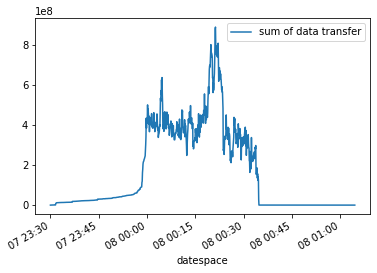

In [9]:
interval_sum.iloc[:,:].plot()

In [10]:
start_interval = '2020-02-08 00:04:40.000'
end_interval = '2020-02-08 00:04:45.056'
df_subset = df[(df['Datetime_firstseen']>=pd.to_datetime(start_interval))&(df['Datetime_firstseen']<pd.to_datetime(end_interval))]

print('Total bytes transfered:\t', end='')
print(sum(df_subset['Bytes']))

print('# of records:\t', end='')
print(df_subset.shape[0])

Total bytes transfered:	401153114
# of records:	23943


['Feb-07-2020 23:59:38.00', 'Feb-07-2020 23:59:38.87', 'Feb-07-2020 23:59:39.75', 'Feb-07-2020 23:59:40.62', 'Feb-07-2020 23:59:41.50', 'Feb-07-2020 23:59:42.37', 'Feb-07-2020 23:59:43.25', 'Feb-07-2020 23:59:44.12', 'Feb-07-2020 23:59:44.99']


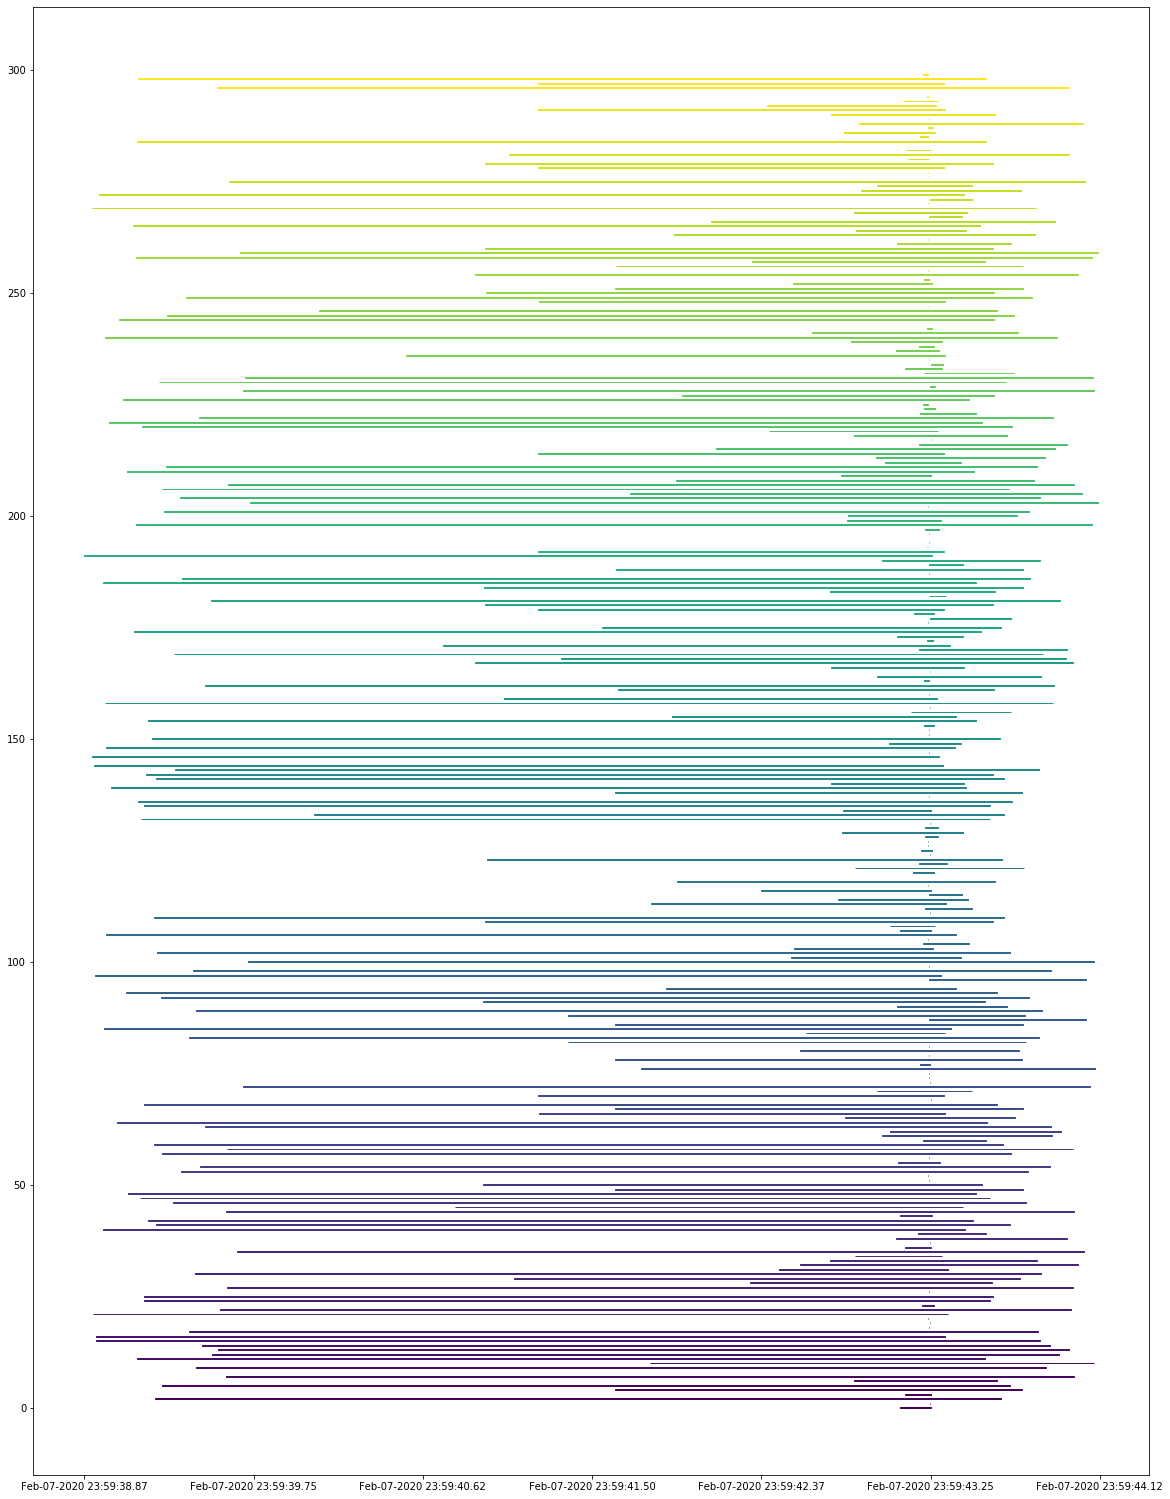

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

num_intervals = 300
start=100
disp = df.iloc[start:num_intervals+start,:].sample(frac=1)
# disp = df.sample(frac=1).iloc[:num_intervals,:]
intervals = disp[['Datetime_firstseen','Datetime_lastseen','Duration']]

min_date=disp.Datetime_firstseen.min() - dt.timedelta(microseconds=disp.Datetime_firstseen.min().microsecond)
max_date=disp.Datetime_lastseen.max() - dt.timedelta(microseconds=disp.Datetime_firstseen.min().microsecond) + dt.timedelta(seconds=1)


idx=0

viridis = plt.cm.get_cmap('viridis', num_intervals)
              
fig, ax = plt.subplots(figsize=(20,27))
for x_s, dur, x_e in zip(intervals['Datetime_firstseen'],intervals['Duration'], intervals['Datetime_lastseen']):
#     print(x_s, dur.total_seconds(), x_e)
    x_s = (x_s - min_date).total_seconds()
    ax.add_patch(plt.Rectangle((x_s,idx),
                               dur.total_seconds(),
                               .2 ,
                               color=viridis(idx / num_intervals)))
    idx+=1

    
ax.autoscale()

date_range = pd.date_range(start=min_date, end=max_date, periods=len(ax.xaxis.get_majorticklocs()))
date_range = ['{:%b-%d-%Y %H:%M:%S}.{:02.0f}'.format(x, x.microsecond / 10000.0) for x in date_range]
print(date_range)
ax.xaxis.set_ticklabels(date_range)
# ax.set_ylim(-2,4)
plt.savefig('./networkflow')
plt.show()


In [12]:
ip_host = pd.read_feather("./feather_hostnames")
ip_host.set_index('ip_addr', inplace=True)

In [13]:
df['Source_Host'] = df.loc[:,'Src_IP_Addr'].map(lambda x: ip_host.loc[x,'hostnames'])
df['Dest_Host'] = df.loc[:,'Dst_IP_Addr'].map(lambda x: ip_host.loc[x,'hostnames'])
df.head()

,Datetime_firstseen,Duration,Protocol,Src_IP_Addr,Src_Port,Direc,Dst_IP_Addr,Dst_Port,Flags,Tos,Packets,Bytes,Flows,Datetime_lastseen,Source_Host,Dest_Host
0,2020-02-07 23:54:53.840,00:04:50.310000,UDP,134.193.92.68,500,->,209.85.235.189,500,........,0,121,52824,1,2020-02-07 23:59:44.150,UMKC,oc-in-f189.1e100.net
1,2020-02-07 23:57:52.820,00:01:51.696000,TCP,172.217.9.132,443,->,134.193.198.19,62831,...AP...,128,2521,1800000,1,2020-02-07 23:59:44.516,dfw25s26-in-f4.1e100.net,UMKC
2,2020-02-07 23:58:01.226,00:01:43.250000,TCP,172.217.1.238,443,->,134.193.198.19,62833,...AP...,0,1225,990522,1,2020-02-07 23:59:44.476,lax17s02-in-f14.1e100.net,UMKC
3,2020-02-07 23:58:34.242,00:01:10.006000,TCP,134.193.254.218,49345,->,150.199.7.126,443,...APRS.,0,715,41665,1,2020-02-07 23:59:44.248,UMKC,Unknown
4,2020-02-07 23:58:43.858,00:01:01.010000,TCP,136.34.135.223,51053,->,134.193.136.193,443,...AP.SF,0,16,1832,1,2020-02-07 23:59:44.868,Unknown,UMKC


In [14]:
df.head()

,Datetime_firstseen,Duration,Protocol,Src_IP_Addr,Src_Port,Direc,Dst_IP_Addr,Dst_Port,Flags,Tos,Packets,Bytes,Flows,Datetime_lastseen,Source_Host,Dest_Host
0,2020-02-07 23:54:53.840,00:04:50.310000,UDP,134.193.92.68,500,->,209.85.235.189,500,........,0,121,52824,1,2020-02-07 23:59:44.150,UMKC,oc-in-f189.1e100.net
1,2020-02-07 23:57:52.820,00:01:51.696000,TCP,172.217.9.132,443,->,134.193.198.19,62831,...AP...,128,2521,1800000,1,2020-02-07 23:59:44.516,dfw25s26-in-f4.1e100.net,UMKC
2,2020-02-07 23:58:01.226,00:01:43.250000,TCP,172.217.1.238,443,->,134.193.198.19,62833,...AP...,0,1225,990522,1,2020-02-07 23:59:44.476,lax17s02-in-f14.1e100.net,UMKC
3,2020-02-07 23:58:34.242,00:01:10.006000,TCP,134.193.254.218,49345,->,150.199.7.126,443,...APRS.,0,715,41665,1,2020-02-07 23:59:44.248,UMKC,Unknown
4,2020-02-07 23:58:43.858,00:01:01.010000,TCP,136.34.135.223,51053,->,134.193.136.193,443,...AP.SF,0,16,1832,1,2020-02-07 23:59:44.868,Unknown,UMKC


In [15]:
df_umkc = df[df.Dest_Host == 'UMKC']
df_umkc.sort_values(by=['Datetime_firstseen'], inplace=True)
df_umkc.reset_index(drop=True, inplace=True)
df_umkc.head()

C:\Users\Geovanni.TheBeast-Snipes\Anaconda3\envs\dsci\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Datetime_firstseen,Duration,Protocol,Src_IP_Addr,Src_Port,Direc,Dst_IP_Addr,Dst_Port,Flags,Tos,Packets,Bytes,Flows,Datetime_lastseen,Source_Host,Dest_Host
0,2020-02-07 23:30:00.534,00:30:00.074000,TCP,18.215.66.244,443,->,134.193.19.39,61753,...AP...,0,380,40711,1,2020-02-08 00:00:00.608,ec2-18-215-66-244.compute-1.amazonaws.com,UMKC
1,2020-02-07 23:30:00.624,00:29:59.946000,TCP,172.217.9.174,443,->,134.193.255.84,61175,...AP.S.,128,3626,1300000,1,2020-02-08 00:00:00.570,dfw25s27-in-f14.1e100.net,UMKC
2,2020-02-07 23:30:00.650,00:30:00.044000,TCP,162.159.128.235,443,->,134.193.97.48,54320,...AP...,0,906,43179,1,2020-02-08 00:00:00.694,Unknown,UMKC
3,2020-02-07 23:30:10.987,00:29:59.928000,TCP,75.87.144.226,59710,->,134.193.136.77,8000,...AP.S.,0,23308,1200000,1,2020-02-08 00:00:10.915,cpe-75-87-144-226.kc.res.rr.com,UMKC
4,2020-02-07 23:30:15.762,00:29:51.518000,TCP,3.222.53.17,443,->,134.193.177.99,62714,...AP.S.,0,188,19984,1,2020-02-08 00:00:07.280,ec2-3-222-53-17.compute-1.amazonaws.com,UMKC


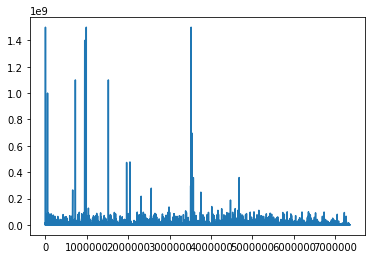

In [16]:
df_umkc.loc[:,'Bytes'].plot()

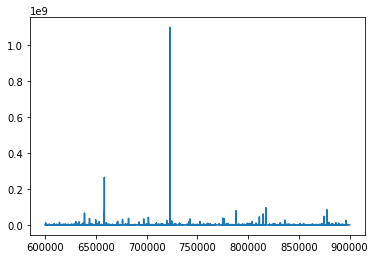

In [17]:
df_umkc.loc[600000:900000,'Bytes'].plot()

In [18]:
df_umkc.loc[600000:900000,'Bytes'].max()

1100000000